##Creating a dummy Database

In [ ]:
import os
import random
from datetime import date, timedelta
from sqlalchemy.orm import declarative_base, relationship, sessionmaker
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Date, Float


Base = declarative_base()

class Customer(Base):
    __tablename__ = 'customers'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    email = Column(String, unique=True)
    orders = relationship("Order", back_populates="customer")

class Product(Base):
    __tablename__ = 'products'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    price = Column(Float)
    orders = relationship("Order", back_populates="product")

class Order(Base):
    __tablename__ = 'orders'
    id = Column(Integer, primary_key=True)
    customer_id = Column(Integer, ForeignKey('customers.id'))
    product_id = Column(Integer, ForeignKey('products.id'))
    quantity = Column(Integer)
    order_date = Column(Date)

    customer = relationship("Customer", back_populates="orders")
    product = relationship("Product", back_populates="orders")

###Inserting data

In [ ]:
if not os.path.exists('example.db'):

  # Create SQLite engine
  engine = create_engine('sqlite:///example.db')
  Base.metadata.create_all(engine)

  # Session
  Session = sessionmaker(bind=engine)
  session = Session()

  # Sample data
  customer_names = ["Alice", "Bob", "Charlie", "Diana", "Edward", "Fiona", "George", "Hannah", "Ian", "Julia"]
  product_names = ["Laptop", "Smartphone", "Tablet", "Headphones", "Monitor", "Keyboard", "Mouse", "Printer", "Camera", "Router"]
  prices = [1200, 800, 300, 150, 250, 100, 50, 200, 500, 120]

  # Add customers
  customers = [Customer(name=name, email=f"{name.lower()}@example.com") for name in customer_names]
  session.add_all(customers)

  # Add products
  products = [Product(name=name, price=price) for name, price in zip(product_names, prices)]
  session.add_all(products)

  # Commit customers and products so we can reference them by ID
  session.commit()

  # Add 10 orders
  for i in range(10):
      order = Order(
          customer_id=random.choice(customers).id,
          product_id=random.choice(products).id,
          quantity=random.randint(1, 5),
          order_date=date(2024, 5, 1) + timedelta(days=i)
      )
      session.add(order)

  session.commit()
  session.close()
print('Database already exists')

Database already exists


In [ ]:
import sqlite3
import contextlib


@contextlib.contextmanager
def sql_cursor(readonly=True):
  conn = sqlite3.connect('example.db')
  cursor = conn.cursor()
  try:
    yield cursor
    if not readonly:
      conn.commit()
  except Exception:
    if not readonly:
      conn.rollback()
    raise
  finally:
    cursor.close()
    conn.close()

In [ ]:
with sql_cursor() as cursor:
  cursor.execute('SELECT * FROM customers')
  for row in cursor.fetchall():
    print(row)

(1, 'Alice', 'alice@example.com')
(2, 'Bob', 'bob@example.com')
(3, 'Charlie', 'charlie@example.com')
(4, 'Diana', 'diana@example.com')
(5, 'Edward', 'edward@example.com')
(6, 'Fiona', 'fiona@example.com')
(7, 'George', 'george@example.com')
(8, 'Hannah', 'hannah@example.com')
(9, 'Ian', 'ian@example.com')
(10, 'Julia', 'julia@example.com')


#Natural Language to SQL

In [ ]:
%pip install -U -q langchain-community langchain-core langgraph langchain-groq transformers langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00


In [ ]:
# from langchain_groq import ChatGroq
# from google.colab import userdata

# os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

# llm = ChatGroq(model='llama-3.3-70b-versatile')

# print(llm.invoke('who are you?').content)

In [ ]:
from langchain_huggingface.llms import HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id(
    model_id="gpt2",
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 10},
)

llm.invoke('who are you?')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu


'who are you? What\'s going on with you?"\n\n"'

In [ ]:
llm.invoke('what can you do?')

"what can you do?\n\nWe're not going to give you a"

In [ ]:
from langchain_community.utilities.sql_database import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///example.db")

print(db.dialect)
print("=" * 30, "\n")
print(db.get_usable_table_names())
print("=" * 30, "\n")
print(db.get_table_info())

sqlite

['customers', 'orders', 'products']


CREATE TABLE customers (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	email VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (email)
)

/*
3 rows from customers table:
id	name	email
1	Alice	alice@example.com
2	Bob	bob@example.com
3	Charlie	charlie@example.com
*/


CREATE TABLE orders (
	id INTEGER NOT NULL, 
	customer_id INTEGER, 
	product_id INTEGER, 
	quantity INTEGER, 
	order_date DATE, 
	PRIMARY KEY (id), 
	FOREIGN KEY(customer_id) REFERENCES customers (id), 
	FOREIGN KEY(product_id) REFERENCES products (id)
)

/*
3 rows from orders table:
id	customer_id	product_id	quantity	order_date
1	6	3	1	2024-05-01
2	3	3	2	2024-05-02
3	10	5	5	2024-05-03
*/


CREATE TABLE products (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	price FLOAT, 
	PRIMARY KEY (id)
)

/*
3 rows from products table:
id	name	price
1	Laptop	1200.0
2	Smartphone	800.0
3	Tablet	300.0
*/


In [ ]:
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END


## Initial state
class AgentState(TypedDict):
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    attempts: int
    relevance: str
    final_answer: str
    sql_error: bool

In [ ]:
## Agent 1: Determines if the user NL-input relevant to the db schema

class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState):
    question = state["question"]
    print(f"Checking relevance of the question: {question}")
    system = """You are a highly skilled SQL expert. Your task is to evaluate whether a given natural language question is relevant to a database based on its schema.

    Use the schema below to determine whether the question can reasonably be answered using the available tables and columns.

    ---
    Schema:
    {schema}
    ---

    Instructions:
    1. Carefully read the user's question.
    2. Check whether the schema contains the necessary tables and columns to answer the question.
    3. If the question can be answered using the schema, respond with **"relevant"**.
    4. If the schema lacks the necessary information, respond with **"not_relevant"**.
    5. Your response must be either **"relevant"** or **"not_relevant"** only—do not explain or elaborate.

    Output Format:
    relevant
    or
    not_relevant
    """
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )

    llm = ChatGroq(model='llama-3.3-70b-versatile')
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    try:
      relevance = relevance_checker.invoke({'schema': db.get_table_info()})
      state["relevance"] = relevance.relevance.lower().strip()
      print(f"Relevance determined: {state['relevance']}")
    except Exception as e:
      print(f"Error during relevance check: {e}")
      state["relevance"] = "not_relevant"
      state["sql_error"] = True
    return state

In [ ]:
## Agent 2: Converts natural language to SQL queries

class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )


def convert_nl_to_sql(state: AgentState):
    question = state["question"]
    print(f"Converting question to SQL for user: {question}")
    system = """
    You are a highly skilled SQL generation assistant. Your task is to convert a user's natural language question into a valid, syntactically correct, and semantically meaningful SQL query using the correct {dialect} dialect.

    Follow these strict rules:

    1. **Use only the tables and columns provided in the schema below**. Do not invent or reference tables/columns that are not explicitly listed.
    2. **Understand the relationships between tables** (e.g., foreign keys, primary keys) and use JOINs accordingly where appropriate.
    3. **Avoid using `SELECT *`**. Instead, return only the specific columns that are relevant to answering the user's question.
    4. Use appropriate **filters, sorting, and grouping** based on the user's intent (e.g., time ranges, categories, totals).
    5. If necessary, use **aggregations** (COUNT, AVG, MAX, etc.) when the question asks for summaries or statistics.
    6. Maintain clarity and simplicity. Prioritize correctness over cleverness.

    Before generating the SQL:
    - Carefully analyze the user's question.
    - Infer any implicit intent (e.g., filtering, ordering) only if it logically follows from the question.
    - Never assume facts that are not supported by the schema or the question.

    Schema:
    {table_info}

    Now, generate the SQL query that answers the following user question:
    """.format(dialect=db.dialect, table_info=db.get_table_info())

    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )

    llm = ChatGroq(model='llama-3.3-70b-versatile')
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    try:
      result = sql_generator.invoke({"question": question})
      state["sql_query"] = result.sql_query.strip()
    except Exception as e:
      print(f"Failed to generate SQL: {e}")
      state["sql_query"] = ""
      state["sql_error"] = True
    print(f"Generated SQL query: {state['sql_query']}")
    return state

In [ ]:
from langchain_community.tools import QuerySQLDatabaseTool
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

## Agent 3: Executes generated SQL query -> retrieve the data from db -> returns updated state
def execute_query(state: AgentState):
    """Execute SQL query and update state based on outcome."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    try:
        result = execute_query_tool.invoke(state["sql_query"])
        state["query_result"] = result
        state["sql_error"] = False
    except Exception as e:
        print(f"Error during SQL execution: {e}")
        state["sql_error"] = True
        state["query_result"] = str(e)
    return state

In [ ]:
## Agent 4: Based on SQL result, generates NL answer
def generate_answer(state: AgentState):
    """Answer question using retrieved information as context."""
    template = PromptTemplate.from_template(
    """You are an intelligent data assistant. Your task is to help answer the user's natural language question by using the provided SQL query and its result.

    You will be given:
    1. The original user question.
    2. The SQL query that was generated to answer the question.
    3. The result returned by executing that SQL query.

    Use this information to provide a helpful, clear, and concise answer to the user's question. If the result is empty or insufficient to answer the question confidently, respond accordingly.

    ---
    Question: {question}
    SQL Query: {sql_query}
    SQL Result: {query_result}
    ---

    Final Answer:""")

    llm_chain = template | llm | StrOutputParser()
    answer = llm_chain.invoke({
        "question": state["question"],
        "sql_query": state["sql_query"],
        "query_result": state["query_result"]
    })
    state["final_answer"] = answer
    return state

In [ ]:
## Agent 5: Generates funny response if the user's query is not relevent to the db
def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """
    You are a witty, charming, and funny assistant whose job is to entertain users when they ask questions unrelated to the database or when no relevant answer can be provided.

    Your responses should:
    - Be playful and light-hearted.
    - Stay appropriate and friendly.
    - Acknowledge that the question isn't answerable via the database.
    - Gently steer the user back on track with a smile (figuratively).

    You are not required to be helpful — just be delightfully unhelpful in a clever way.
    """

    human_message = f"""
    The user asked a question that is unrelated to the database:
    '{state['question']}'
    Craft a humorous and creative response."""

    funny_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", human_message),
    ])

    llm = ChatGroq(model='llama-3.3-70b-versatile')
    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["final_answer"] = message
    print("Generated funny response.")
    return state

In [ ]:
## Agent 6: Rewrites the og question if there isn't enough info
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """
    You are an expert in SQL and natural language understanding.

    Your task is to **rewrite a user's natural language question** so that:
    - It is clear, complete, and unambiguous.
    - It is optimized to be converted into a precise and valid SQL query.
    - All necessary details (e.g. filters, relationships between tables, required joins, and any implied logic) are included.
    - The reformulated version preserves the intent and meaning of the original question but improves its structure for programmatic interpretation.

    Avoid making assumptions not supported by the original question or schema.
    """

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Original Question: {question}\n\nRewrite this question to make it clearer and more suitable for SQL generation, including all relevant details.")
    ])

    llm = ChatGroq(model='llama-3.3-70b-versatile', temperature=0)
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm

    rewritten = rewriter.invoke({"question": question})
    state["rewritten_question"] = rewritten.question
    state["attempts"] = state.get("attempts", 0) + 1
    print(f"Rewritten question: {state['rewritten_question']}")
    return state

In [ ]:
## Conditionnal nodes
def end_max_iter(state: AgentState):
    print("Maximum attempts reached. Ending the workflow.")
    state["query_result"] = "Please try again."
    return state

def router(state: AgentState):
    print("Routing based on relevance...")
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "generate_funny_response"

def check_attempts(state: AgentState):
    print(f"Attempt #{state['attempts']}")
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iter"

def execute_sql(state: AgentState):
    print("Routing based on SQL execution result...")
    if not state.get("sql_error", False):
        return "generate_answer"
    else:
        return "regenerate_query"

In [ ]:
## Constructing the the Graph
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_query)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("end_max_iter", end_max_iter)

# Conditional logic
workflow.add_conditional_edges(
    "check_relevance",
    router,
    {
        "convert_to_sql": "convert_to_sql",
        "generate_funny_response": "generate_funny_response",
    },
)

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql,
    {
        "generate_answer": "generate_answer",
        "regenerate_query": "regenerate_query",
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts,
    {
        "convert_to_sql": "convert_to_sql",
        "end_max_iter": "end_max_iter",
    },
)

# Terminal paths
workflow.add_edge("generate_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iter", END)

# Start point
workflow.set_entry_point("check_relevance")

# Compile
app = workflow.compile()

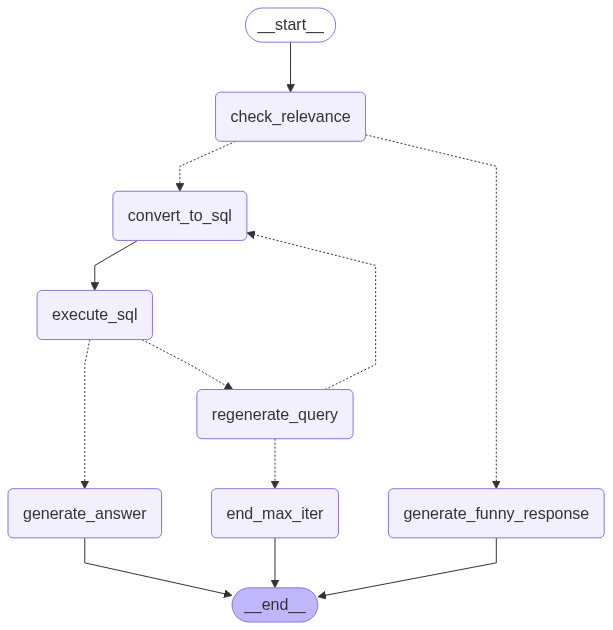

In [ ]:
from IPython.display import Image, display

try:
  display(Image(app.get_graph(xray=True).draw_mermaid_png(max_retries=5, retry_delay=2.0)))
except:
  pass

In [ ]:
# Initialize state
state = {
    "question": "",
    "chat_history": [], # adding memory
    "sql_query": "",
    "query_result": "",
    "query_rows": [],
    "attempts": 0,
    "relevance": "",
    "final_answer": "",
    "sql_error": False,
}


while True:
    user_input = input("User: ").strip()
    if user_input.lower() in ["exit", "quit"]:
        print("Conversation ended.")
        break

    state["question"] = user_input
    state["attempts"] = 0  # reset attempts each new question

    result = app.invoke(state)

    answer = result.get("final_answer", "No response available.")

    print(f"Assistant: {answer}\n")

    state["chat_history"].append({"user": user_input, "assistant": answer})


User: how many customers are there?
Checking relevance of the question: how many customers are there?
Relevance determined: relevant
Routing based on relevance...
Converting question to SQL for user: how many customers are there?
Generated SQL query: SELECT COUNT(id) FROM customers
Routing based on SQL execution result...
Assistant: There are 10 customers.

User: what are their names?
Checking relevance of the question: what are their names?
Relevance determined: relevant
Routing based on relevance...
Converting question to SQL for user: what are their names?
Generated SQL query: SELECT name FROM customers
Routing based on SQL execution result...
Assistant: The names are: Alice, Bob, Charlie, Diana, Edward, Fiona, George, Hannah, Ian, and Julia.

User: What is the total number of orders in the system?
Checking relevance of the question: What is the total number of orders in the system?
Relevance determined: relevant
Routing based on relevance...
Converting question to SQL for user: Wha